In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
import torch.utils.data as Data
from torch.autograd import Variable
import os
import plotly.graph_objects as go
from sklearn.preprocessing import LabelEncoder
import joblib


## Read the Data

In [3]:
paysim=pd.read_excel('/Users/baujsiu/Downloads/data.xlsx')

paysim.head()

,Unnamed: 0,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,orig_diff,dest_diff,surge,freq_dest
0,0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,0,1,0,0
1,1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,0,1,0,0
2,2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,0,1,0,0
3,3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,0,1,0,0
4,4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,0,1,0,0


In [4]:
fraud  =  paysim['isFraud']
flaggedfraud  =  paysim['isFlaggedFraud']

## split the data with Fraud

In [5]:
import pandas as pd

fraud_counts = paysim['isFraud'].value_counts()
print("isFraud 0 的值有幾個:", fraud_counts[0])
print("isFraud 1 的值有幾個:", fraud_counts[1])




isFraud 0 的值有幾個: 49900
isFraud 1 的值有幾個: 100


In [140]:
paysim.head()

,Unnamed: 0,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,orig_diff,dest_diff,surge,freq_dest
0,0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,0,1,0,0
1,1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,0,1,0,0
2,2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,0,1,0,0
3,3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,0,1,0,0
4,4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,0,1,0,0


## encoder file

In [141]:
label_encoder = LabelEncoder()

paysim['type'] = label_encoder.fit_transform(paysim['type'])

print("轉換後的'type'列:")
print(paysim['type'])

print("\nLabelEncoder 對應的類別和數字:")
for class_index, class_label in enumerate(label_encoder.classes_):
    print(f"{class_label}: {class_index}")

轉換後的'type'列:
0        3
1        3
2        4
3        1
4        3
        ..
49995    3
49996    3
49997    3
49998    3
49999    3
Name: type, Length: 50000, dtype: int64

LabelEncoder 對應的類別和數字:
CASH_IN: 0
CASH_OUT: 1
DEBIT: 2
PAYMENT: 3
TRANSFER: 4


In [142]:
joblib.dump(label_encoder, 'label_encoder.pkl')


['label_encoder.pkl']

## select the OOD(Fraud Data) 

In [143]:
paysim_fraud_0 = paysim[paysim['isFraud'] == 0]
paysim_fraud_1 = paysim[paysim['isFraud'] == 1]

# 顯示結果
print("isFraud 為 0 的資料集:")
print(paysim_fraud_0)
print("\nisFraud 為 1 的資料集:")
print(paysim_fraud_1)

isFraud 為 0 的資料集:
       Unnamed: 0  step  type    amount     nameOrig  oldbalanceOrg  \
0               0     1     3   9839.64  C1231006815      170136.00   
1               1     1     3   1864.28  C1666544295       21249.00   
4               4     1     3  11668.14  C2048537720       41554.00   
5               5     1     3   7817.71    C90045638       53860.00   
6               6     1     3   7107.77   C154988899      183195.00   
...           ...   ...   ...       ...          ...            ...   
49995       49995     9     3   1322.91  C1402545110     1208457.61   
49996       49996     9     3   6900.48   C517372485     1207134.71   
49997       49997     9     3  17399.12  C1948160352     1200234.22   
49998       49998     9     3   5485.20  C1586381033     1182835.10   
49999       49999     9     3    629.44   C741191323     1177349.90   

       newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  isFraud  \
0           160296.36  M1979787155             0.0

# Drop some unnecessary Feature

In [144]:
output = paysim_fraud_0['type']

input_data = paysim_fraud_0.drop(columns=['type','nameOrig', 'nameDest','isFraud','isFlaggedFraud','Unnamed: 0'])


## Split Train and Test1 Test2 Test3

In [145]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(input_data, output, test_size=0.8, random_state=42)
X_test1, X_temp, y_test1, y_temp = train_test_split(X_temp, y_temp, test_size=0.6667, random_state=42)
X_test2, X_test3, y_test2, y_test3 = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("訓練集大小:", X_train.shape, y_train.shape)
print("測試集1大小:", X_test1.shape, y_test1.shape)
print("測試集2大小:", X_test2.shape, y_test2.shape)
print("測試集3大小:", X_test3.shape, y_test3.shape)


訓練集大小: (9980, 10) (9980,)
測試集1大小: (13305, 10) (13305,)
測試集2大小: (13307, 10) (13307,)
測試集3大小: (13308, 10) (13308,)


In [146]:
X_test1.to_csv('X_test1.csv', index=False)
y_test1.to_csv('y_test1.csv', index=False)

X_test2.to_csv('X_test2.csv', index=False)
y_test2.to_csv('y_test2.csv', index=False)

X_test3.to_csv('X_test3.csv', index=False)
y_test3.to_csv('y_test3.csv', index=False)

In [147]:
from torch.utils.data import DataLoader, TensorDataset


## 轉tensor

In [148]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test1_scaled = scaler.transform(X_test1)
X_test2_scaled = scaler.transform(X_test2)
X_test3_scaled = scaler.transform(X_test3)

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test1_tensor = torch.tensor(X_test1_scaled, dtype=torch.float32)
X_test2_tensor = torch.tensor(X_test2_scaled, dtype=torch.float32)
X_test3_tensor = torch.tensor(X_test3_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)  
y_test1_tensor = torch.tensor(y_test1.values, dtype=torch.long)
y_test2_tensor = torch.tensor(y_test2.values, dtype=torch.long)
y_test3_tensor = torch.tensor(y_test3.values, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test1_dataset = TensorDataset(X_test1_tensor, y_test1_tensor)
test2_dataset = TensorDataset(X_test2_tensor, y_test2_tensor)
test3_dataset = TensorDataset(X_test3_tensor, y_test3_tensor)

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test1_loader = DataLoader(test1_dataset, batch_size=batch_size)
test2_loader = DataLoader(test2_dataset, batch_size=batch_size)
test3_loader = DataLoader(test3_dataset, batch_size=batch_size)



## swag function

In [149]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
import torch.nn.functional as F
class SWAG(nn.Module):
    def __init__(self, base_model, no_cov_mat=True, max_num_models=5):
        super(SWAG, self).__init__()
        self.base_model = base_model
        self.no_cov_mat = no_cov_mat
        self.max_num_models = max_num_models
        self.registered = False
        self.models_collected = 0

        # 用于存储模型参数的均值和平方均值
        self.mean = []
        self.sq_mean = []

    def register(self):
        # 注册基础模型的初始参数
        for param in self.base_model.parameters():
            self.mean.append(param.data.clone().detach())
            self.sq_mean.append(param.data.clone().detach() ** 2)
        self.registered = True

    def collect_model(self, model):
        if not self.registered:
            self.register()

        with torch.no_grad():
            for i, param in enumerate(model.parameters()):
                # 更新参数的均值
                self.mean[i].mul_(self.models_collected / (self.models_collected + 1.0))
                self.mean[i].add_(param.data / (self.models_collected + 1.0))

                # 更新参数的平方均值
                self.sq_mean[i].mul_(self.models_collected / (self.models_collected + 1.0))
                self.sq_mean[i].add_(param.data ** 2 / (self.models_collected + 1.0))

        self.models_collected += 1

    def sample(self, scale=0.3):
        if self.models_collected == 0:
            raise ValueError("No models collected")
        
        with torch.no_grad():
            for i, param in enumerate(self.base_model.parameters()):
                mean = self.mean[i]
                sq_mean = self.sq_mean[i]
                # 计算参数的标准差
                std_dev = torch.sqrt(torch.clamp(sq_mean - mean ** 2, min=1e-6))
                # 从参数分布中采样
                sampled_param = mean + scale * torch.randn_like(mean) * std_dev
                param.data.copy_(sampled_param)

    def forward(self, x):
        return self.base_model(x)




## train and test function

In [150]:
def train(loader, model, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(loader):
        optimizer.zero_grad()
        output = model(data)
        loss = torch.nn.functional.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(loader.dataset)} ({100. * batch_idx / len(loader):.0f}%)]\tLoss: {loss.item():.6f}')
def test(loader, model):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in loader:
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # 累加損失
            pred = output.argmax(dim=1, keepdim=True)  # 獲得預測最大值的索引
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)

    test_loss /= total
    accuracy = 100. * correct / total
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{total} ({accuracy:.0f}%)')
    return accuracy  # 返回準確率



## base model

In [151]:
import torch
import torch.nn as nn


class Trade_Model(nn.Module):
    def __init__(self):
        super(Trade_Model, self).__init__()
        self.fc1 = nn.Linear(10, 128)  # 9 input features, 128 hidden units
        self.fc2 = nn.Linear(128, 64)  # 128 hidden units, 64 hidden units
        self.fc3 = nn.Linear(64, 32)   # 64 hidden units, 32 hidden units
        self.fc4 = nn.Linear(32, 5)    # 32 hidden units, 5 output classes

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x


model = Trade_Model()


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)


## train the swag 

In [152]:
model = Trade_Model()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
swag_model = SWAG(model, no_cov_mat=True, max_num_models=10)

epochs = 50
for epoch in range(epochs):
    train(train_loader, model, optimizer, epoch)
    swag_model.collect_model(model)

swag_model.sample(0.1)

Train Epoch: 0 [0/9980 (0%)]	Loss: 1.591753
Train Epoch: 0 [6400/9980 (64%)]	Loss: 0.642403
Train Epoch: 1 [0/9980 (0%)]	Loss: 0.539765
Train Epoch: 1 [6400/9980 (64%)]	Loss: 0.564304
Train Epoch: 2 [0/9980 (0%)]	Loss: 0.471508
Train Epoch: 2 [6400/9980 (64%)]	Loss: 0.284435
Train Epoch: 3 [0/9980 (0%)]	Loss: 0.420950
Train Epoch: 3 [6400/9980 (64%)]	Loss: 0.378296
Train Epoch: 4 [0/9980 (0%)]	Loss: 0.409527
Train Epoch: 4 [6400/9980 (64%)]	Loss: 0.277156
Train Epoch: 5 [0/9980 (0%)]	Loss: 0.229396
Train Epoch: 5 [6400/9980 (64%)]	Loss: 0.464668
Train Epoch: 6 [0/9980 (0%)]	Loss: 0.233116
Train Epoch: 6 [6400/9980 (64%)]	Loss: 0.243923
Train Epoch: 7 [0/9980 (0%)]	Loss: 0.366047
Train Epoch: 7 [6400/9980 (64%)]	Loss: 0.567355
Train Epoch: 8 [0/9980 (0%)]	Loss: 0.253467
Train Epoch: 8 [6400/9980 (64%)]	Loss: 0.247222
Train Epoch: 9 [0/9980 (0%)]	Loss: 0.265225
Train Epoch: 9 [6400/9980 (64%)]	Loss: 0.282171
Train Epoch: 10 [0/9980 (0%)]	Loss: 0.129934
Train Epoch: 10 [6400/9980 (64%)]	L

## train the simple model

In [153]:
simple_model = Trade_Model()
optimizer_simple = torch.optim.SGD(simple_model.parameters(), lr=0.01, momentum=0.9)

for epoch in range(epochs):
    train(train_loader, simple_model, optimizer_simple, epoch)


Train Epoch: 0 [0/9980 (0%)]	Loss: 1.655307
Train Epoch: 0 [6400/9980 (64%)]	Loss: 0.817942
Train Epoch: 1 [0/9980 (0%)]	Loss: 0.575353
Train Epoch: 1 [6400/9980 (64%)]	Loss: 0.439808
Train Epoch: 2 [0/9980 (0%)]	Loss: 0.454230
Train Epoch: 2 [6400/9980 (64%)]	Loss: 0.464441
Train Epoch: 3 [0/9980 (0%)]	Loss: 0.201715
Train Epoch: 3 [6400/9980 (64%)]	Loss: 0.209608
Train Epoch: 4 [0/9980 (0%)]	Loss: 0.368439
Train Epoch: 4 [6400/9980 (64%)]	Loss: 0.541630
Train Epoch: 5 [0/9980 (0%)]	Loss: 0.199746
Train Epoch: 5 [6400/9980 (64%)]	Loss: 0.443614
Train Epoch: 6 [0/9980 (0%)]	Loss: 0.303492
Train Epoch: 6 [6400/9980 (64%)]	Loss: 0.441120
Train Epoch: 7 [0/9980 (0%)]	Loss: 0.443479
Train Epoch: 7 [6400/9980 (64%)]	Loss: 0.303213
Train Epoch: 8 [0/9980 (0%)]	Loss: 0.196875
Train Epoch: 8 [6400/9980 (64%)]	Loss: 0.220293
Train Epoch: 9 [0/9980 (0%)]	Loss: 0.267406
Train Epoch: 9 [6400/9980 (64%)]	Loss: 0.217150
Train Epoch: 10 [0/9980 (0%)]	Loss: 0.356213
Train Epoch: 10 [6400/9980 (64%)]	L

## Test different dataloader in swag and simple model

In [154]:
test(test1_loader, swag_model)
test(test2_loader, swag_model)
test(test3_loader, swag_model)



Test set: Average loss: 0.2458, Accuracy: 12231/13305 (92%)

Test set: Average loss: 0.2397, Accuracy: 12258/13307 (92%)

Test set: Average loss: 0.2471, Accuracy: 12221/13308 (92%)


91.83198076345056

## save the model

In [155]:
# Save the models
torch.save(swag_model.state_dict(), 'swag_model.pt')
torch.save(simple_model.state_dict(), 'simple_model.pt')

In [156]:
import joblib


X_train_scaled = scaler.fit_transform(X_train)
joblib.dump(scaler, 'scaler.pkl')



['scaler.pkl']

In [157]:
test(test1_loader, simple_model)
test(test2_loader, simple_model)
test(test3_loader, simple_model)



Test set: Average loss: 0.2463, Accuracy: 12284/13305 (92%)

Test set: Average loss: 0.2338, Accuracy: 12303/13307 (92%)

Test set: Average loss: 0.2430, Accuracy: 12266/13308 (92%)


92.17012323414488

In [158]:
OOD_output = paysim_fraud_1['type']

OOD_input_data = paysim_fraud_1.drop(columns=['type','nameOrig', 'nameDest','isFraud','isFlaggedFraud','Unnamed: 0'])
OOD_input_data.shape

(100, 10)

In [159]:
OOD_output.to_csv('OOD_output.csv', index=False)
OOD_input_data.to_csv('OOD_input_data.csv', index=False)

In [160]:
X_testOOD_scaled = scaler.transform(OOD_input_data)

X_testOOD_tensor = torch.tensor(X_testOOD_scaled, dtype=torch.float32)
y_testOOD_tensor = torch.tensor(OOD_output.values, dtype=torch.long)
testOOD_dataset = TensorDataset(X_testOOD_tensor, y_testOOD_tensor)
batch_size = 64

testOOD_loader = DataLoader(testOOD_dataset, batch_size=batch_size)

In [161]:
test(testOOD_loader, swag_model)



Test set: Average loss: 4.4335, Accuracy: 28/100 (28%)


28.0

In [162]:
test(testOOD_loader, simple_model)



Test set: Average loss: 5.3107, Accuracy: 24/100 (24%)


24.0

## plot the probablity 

In [163]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

# CASH_IN: 0
# CASH_OUT: 1
# DEBIT: 2
# PAYMENT: 3
# TRANSFER: 4
classes = ['CASH_IN', 'CASH_OUT', 'DEBIT', 'PAYMENT', 'TRANSFER']

def test_plot(loader, model):
    model.eval()
    with torch.no_grad():
        for idx in range(len(loader.dataset)):  # Iterate over the dataset
            data, target = loader.dataset[idx]
            data = data.unsqueeze(0)  # Add batch dimension
            output = model(data)
            probabilities = F.softmax(output, dim=1)
            sample_probs = probabilities[0].numpy()
            correct_label = target.item() if hasattr(target, 'item') else target  # Check if target is a tensor
            predicted_label = output.argmax().item()
            if predicted_label == correct_label:
                plt.figure(dpi=100)  # Set DPI for better quality
                plt.bar(range(len(sample_probs)), sample_probs, color='blue', alpha=0.9)  # Adjust alpha value here
                plt.xlabel('Class')
                plt.ylabel('Probability')
                plt.title(f'Probability Distribution for Correct Sample {idx+1}')
                plt.xticks(range(len(sample_probs)), classes, rotation=45)  # Set class labels and rotate them for better readability
                plt.ylim(0, 1)
                plt.axvline(x=correct_label, color='green', linestyle='--', label='True Class')
                plt.axvline(x=predicted_label, color='red', linestyle='--', label='Predicted Class')
                plt.legend()
                plt.show()


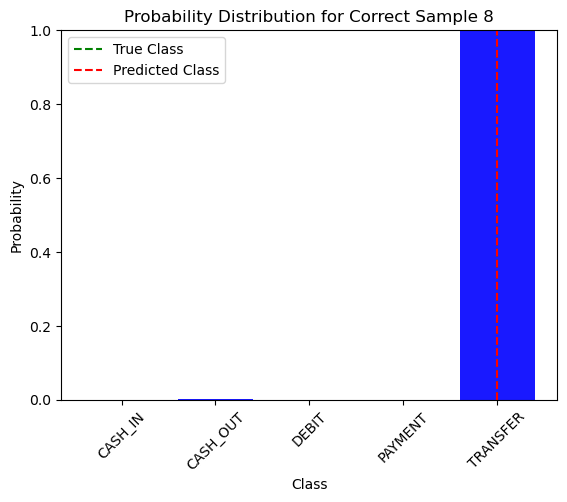

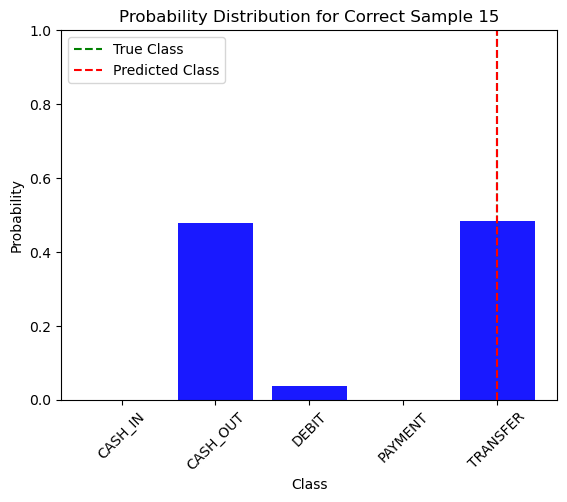

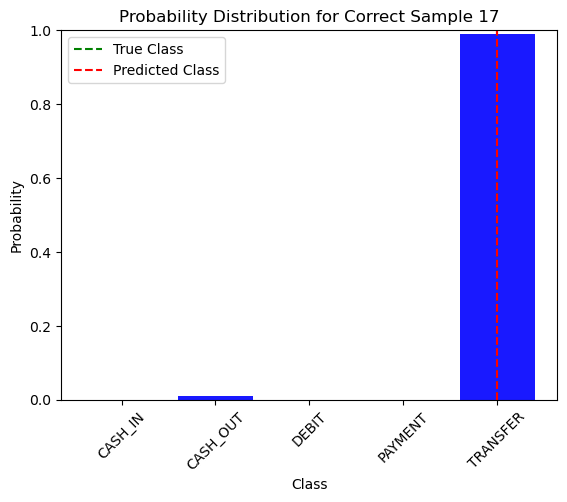

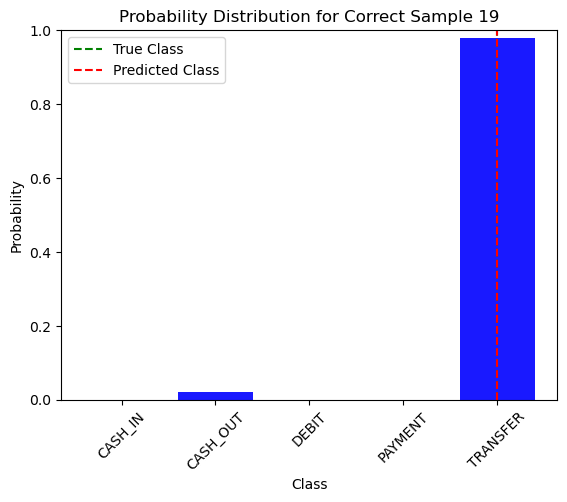

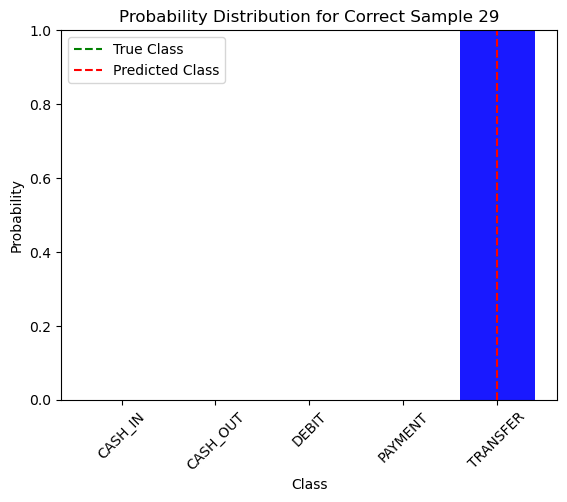

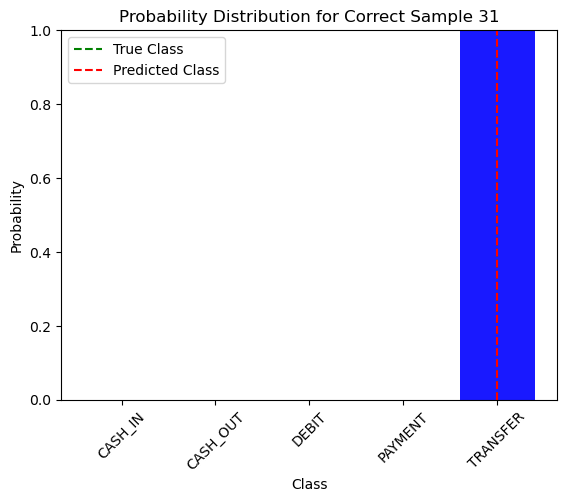

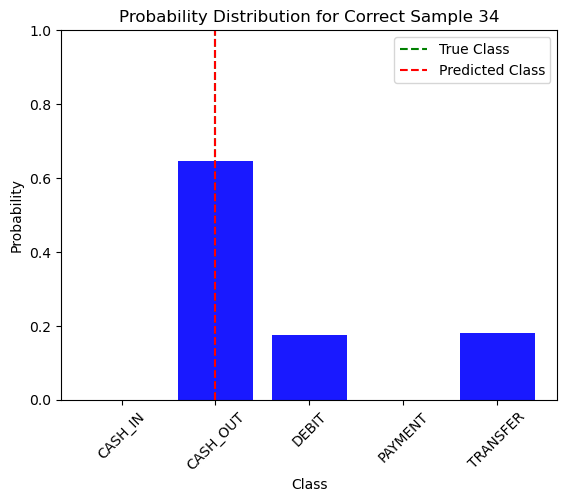

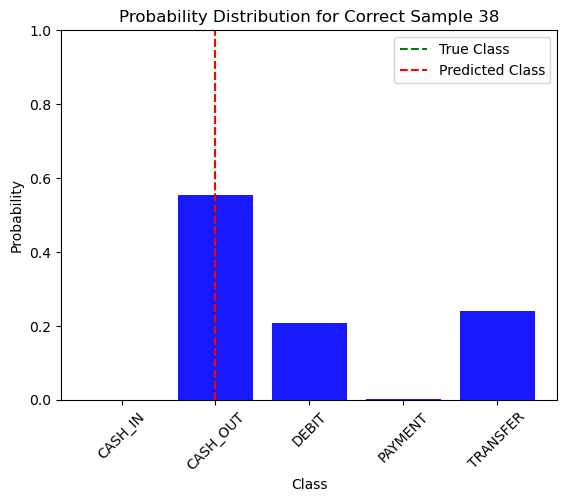

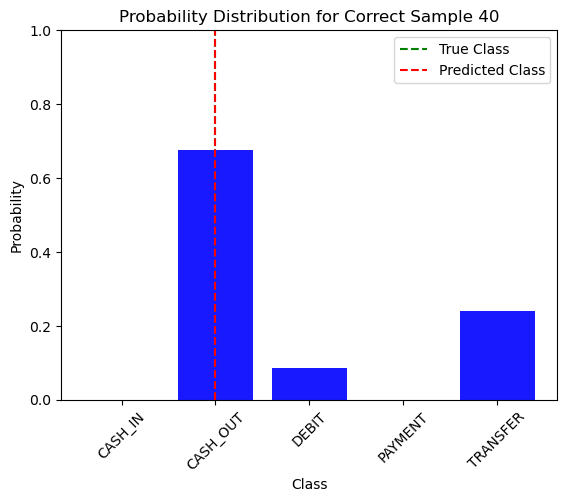

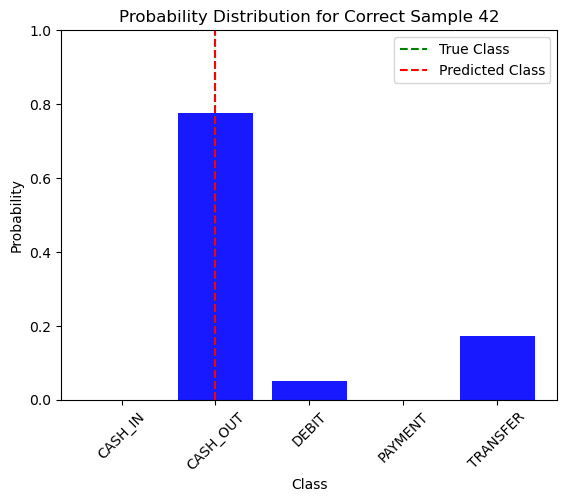

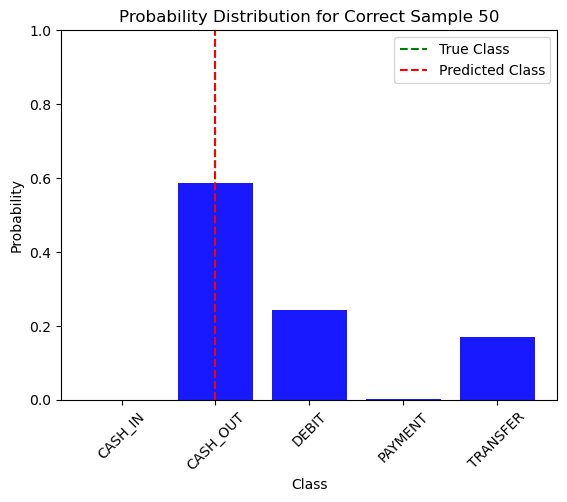

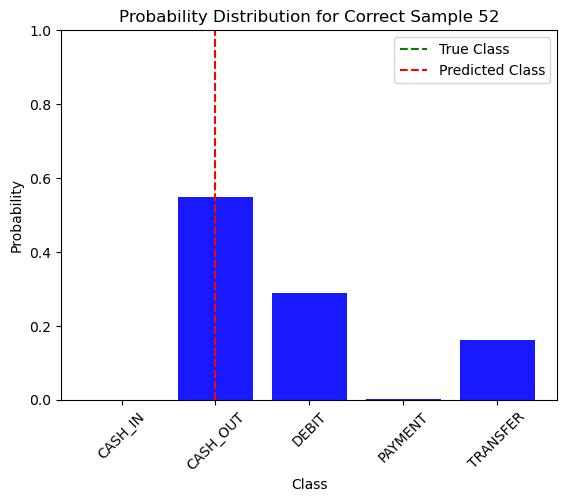

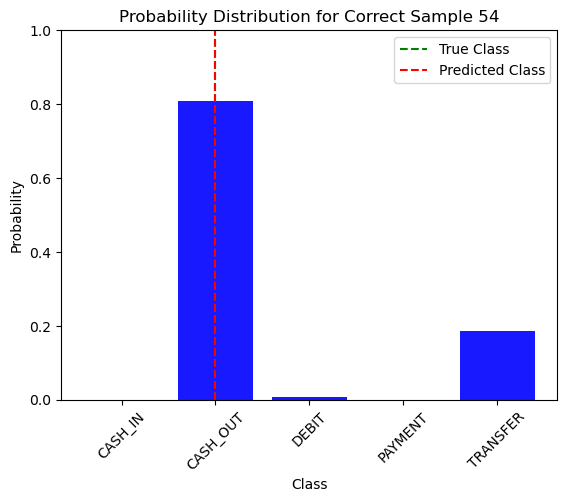

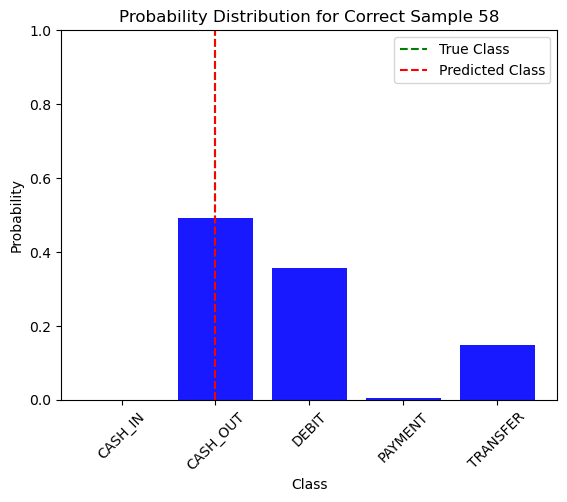

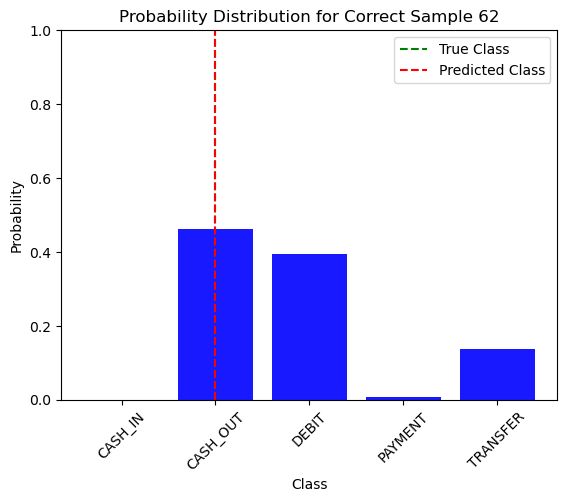

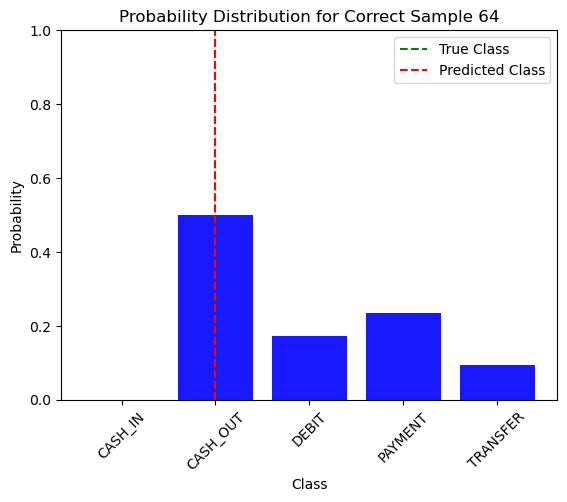

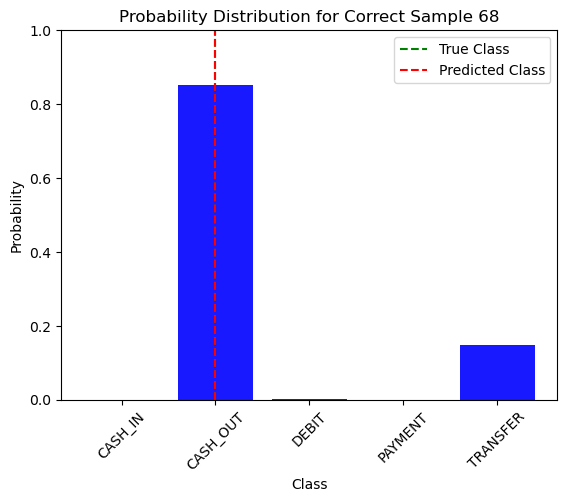

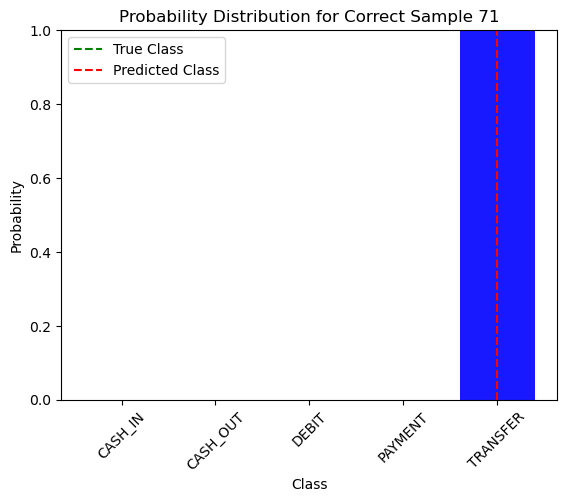

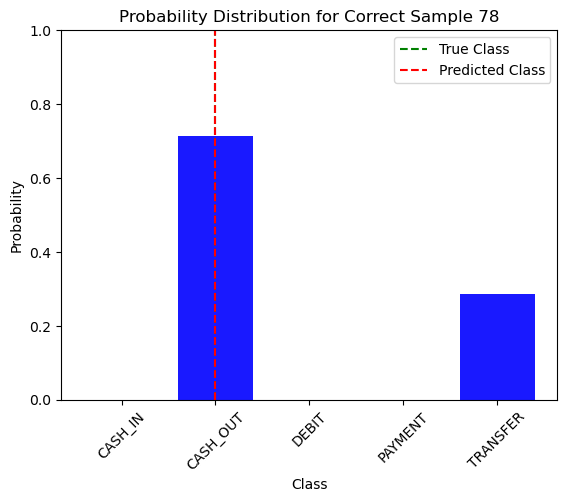

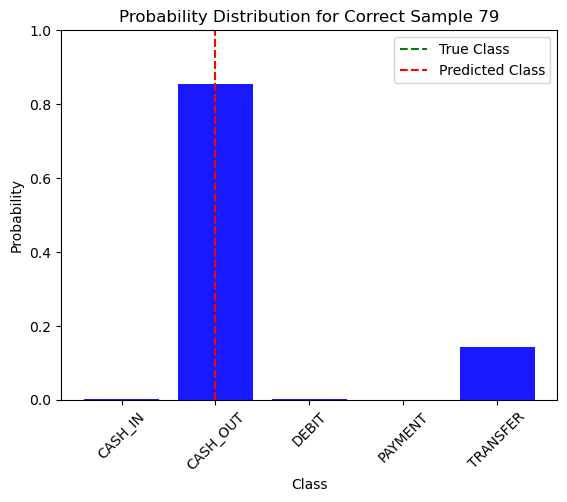

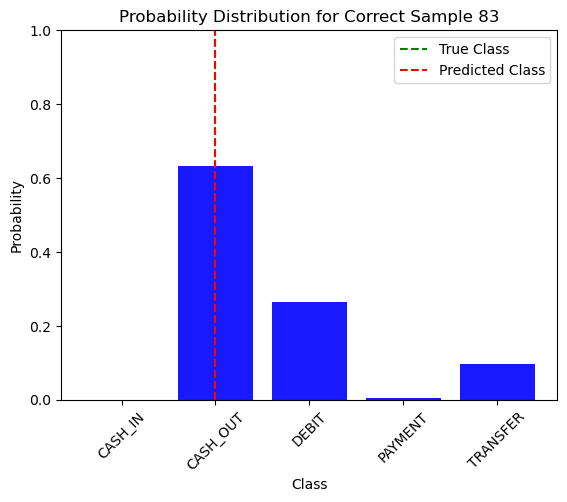

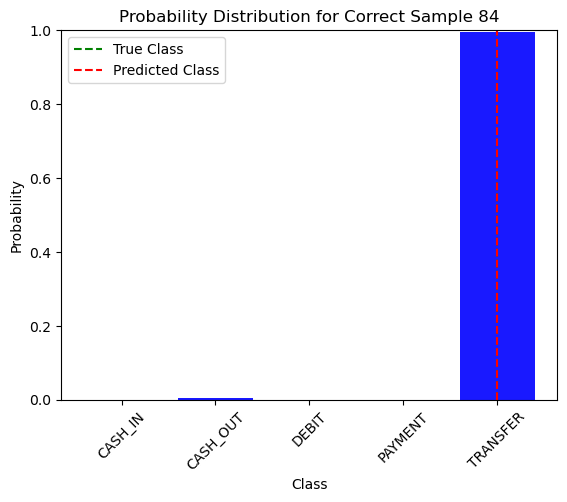

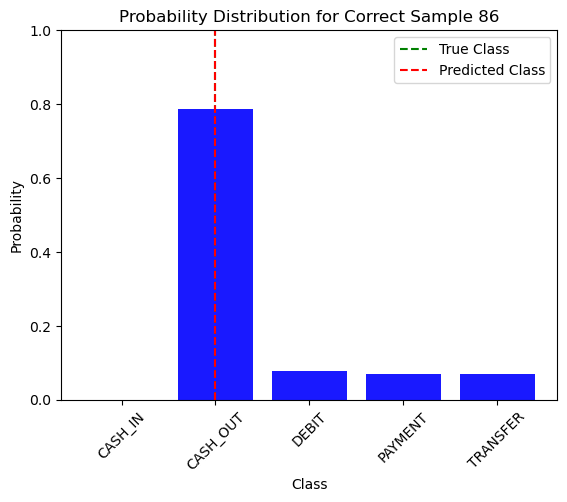

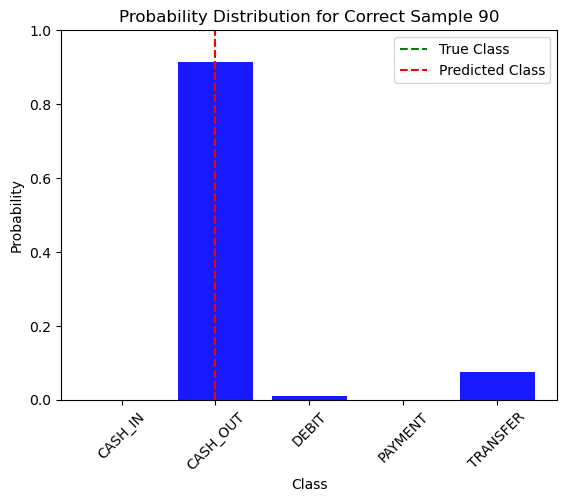

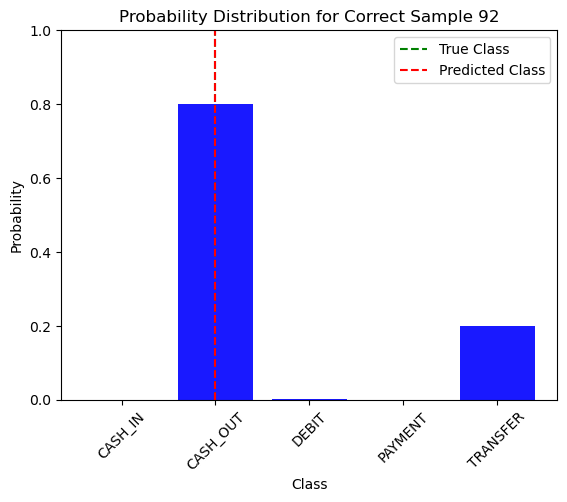

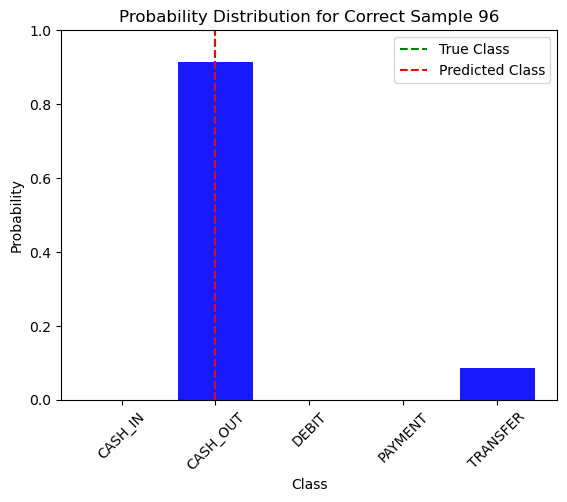

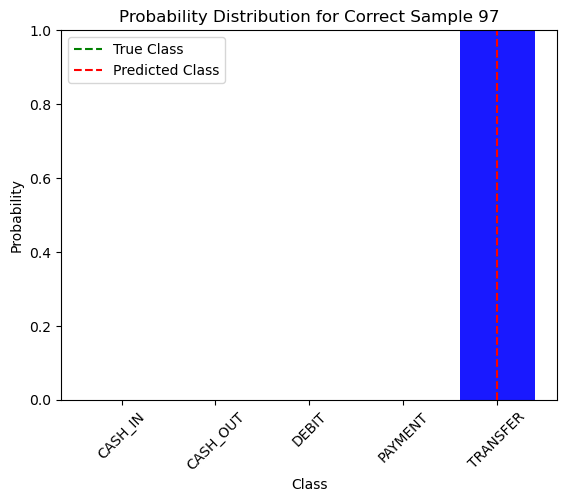

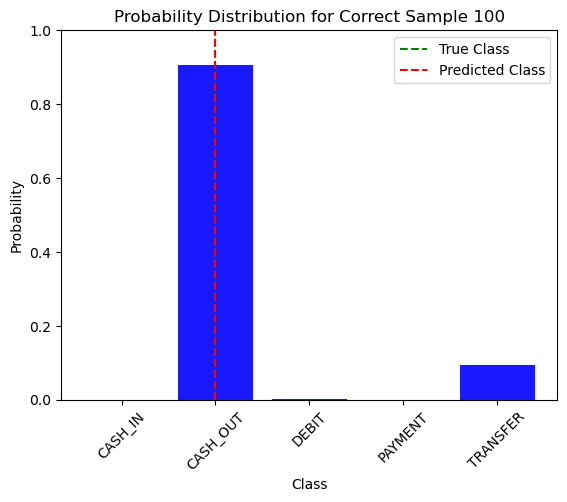

In [164]:
test_plot(testOOD_loader, swag_model)


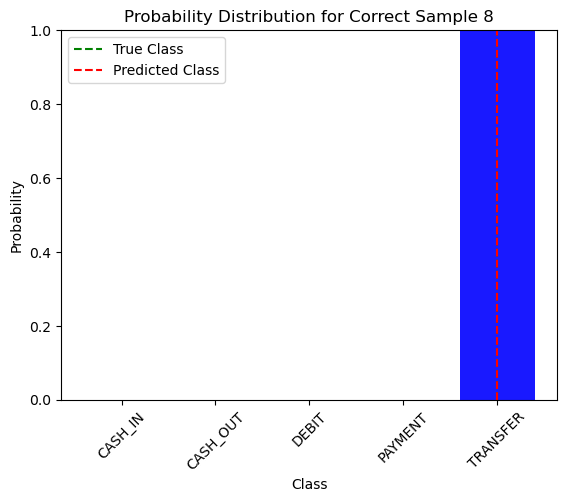

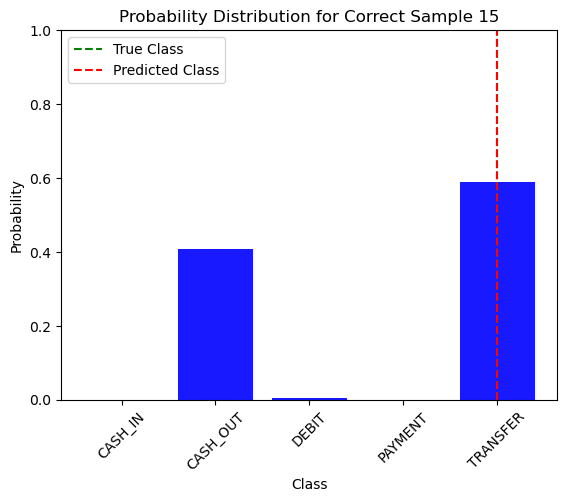

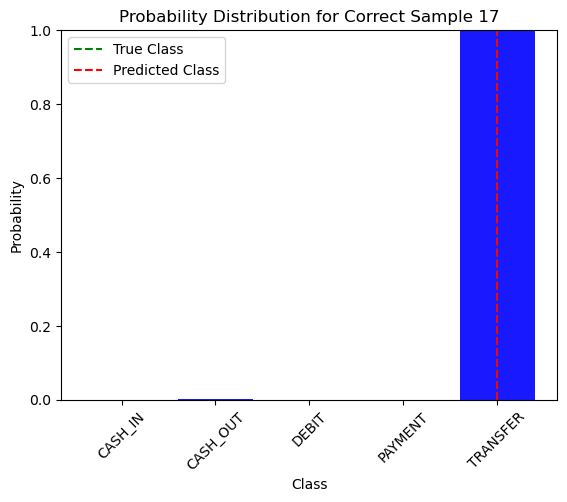

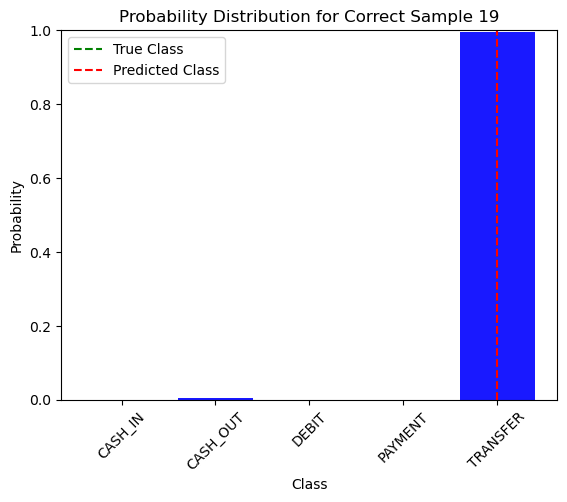

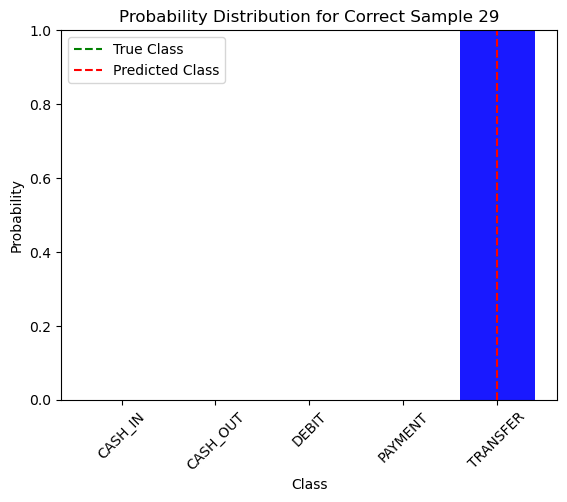

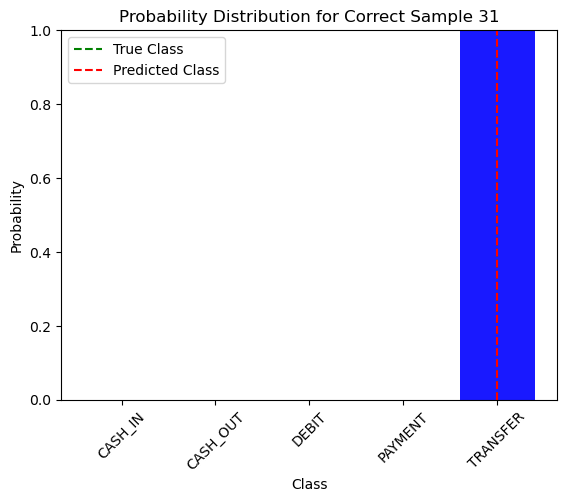

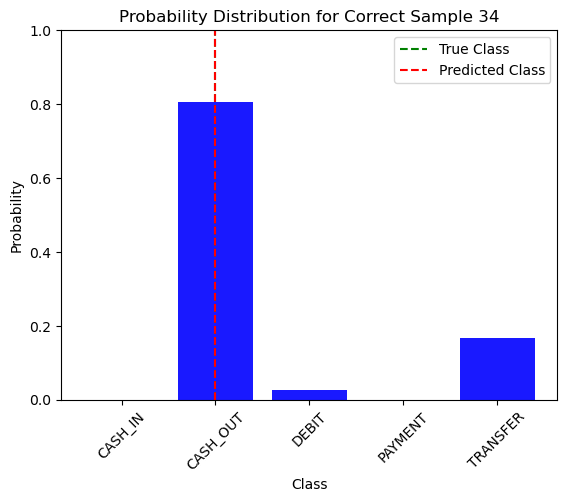

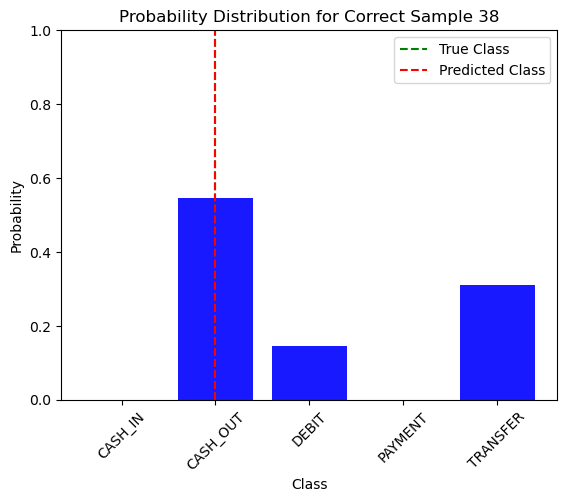

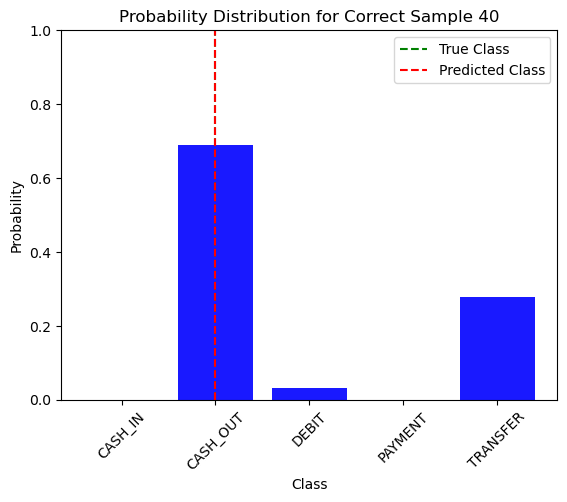

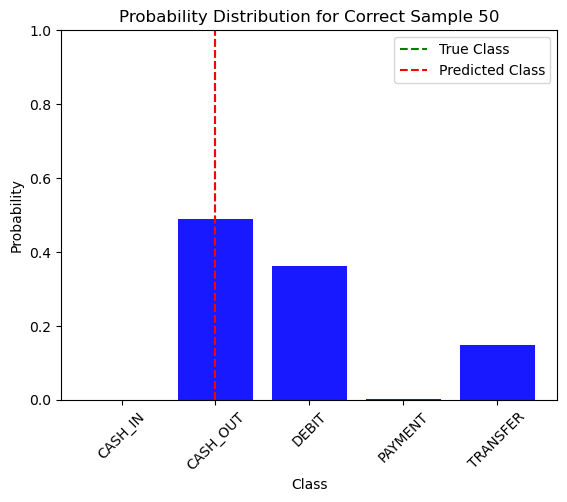

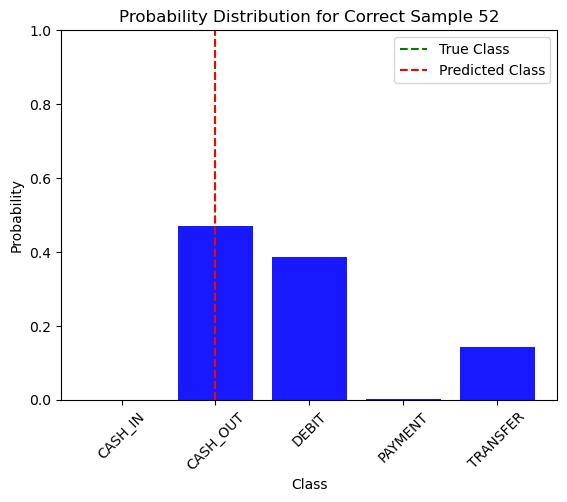

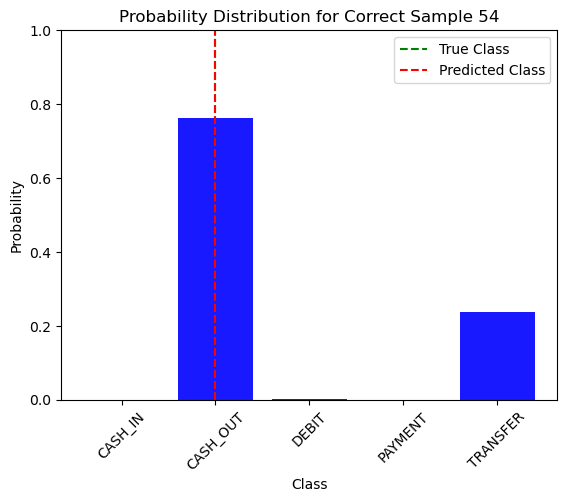

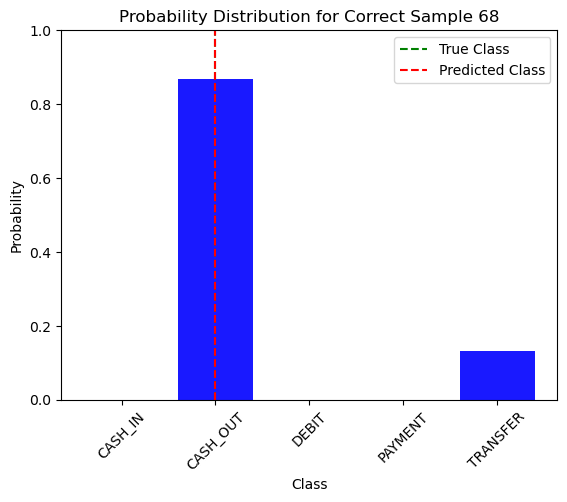

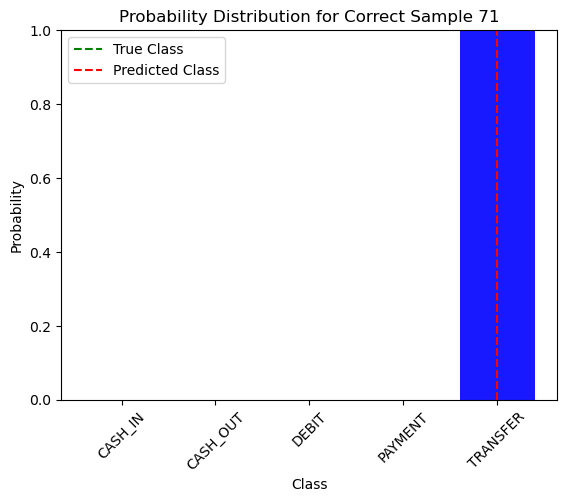

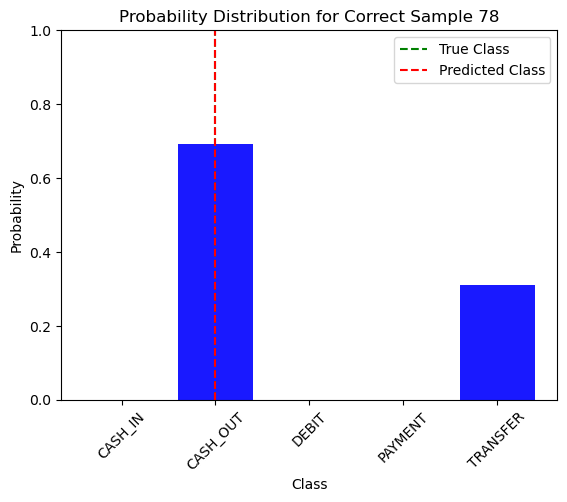

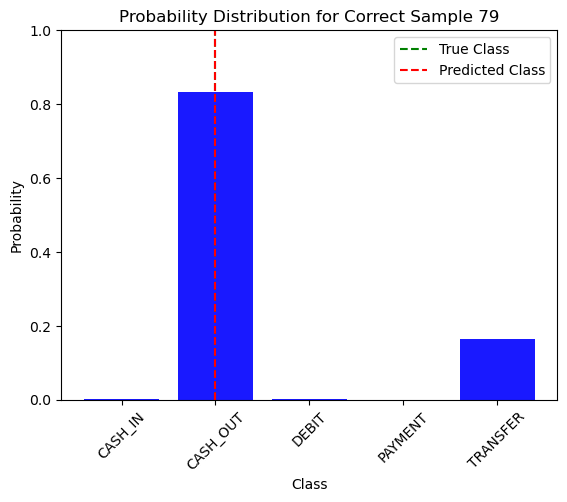

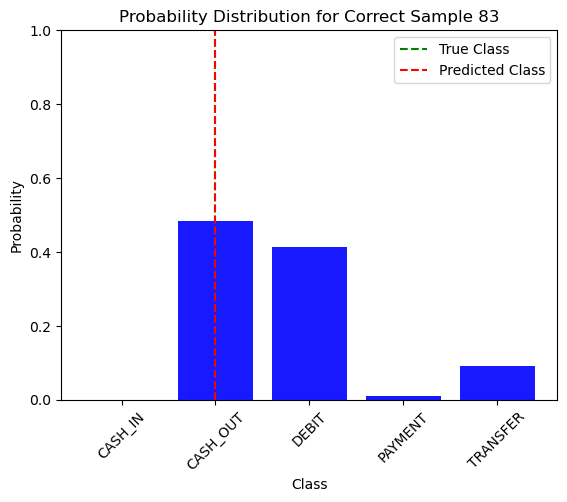

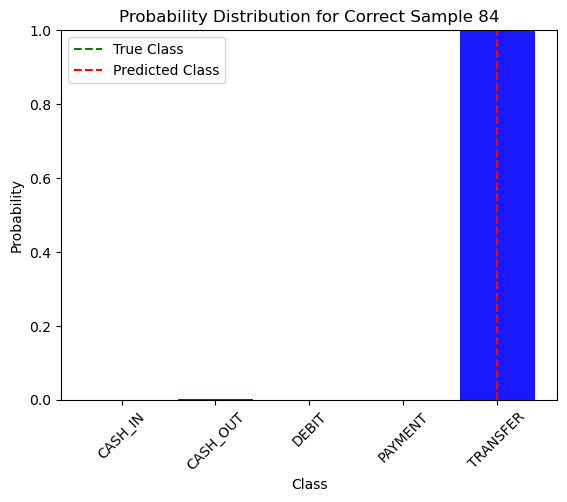

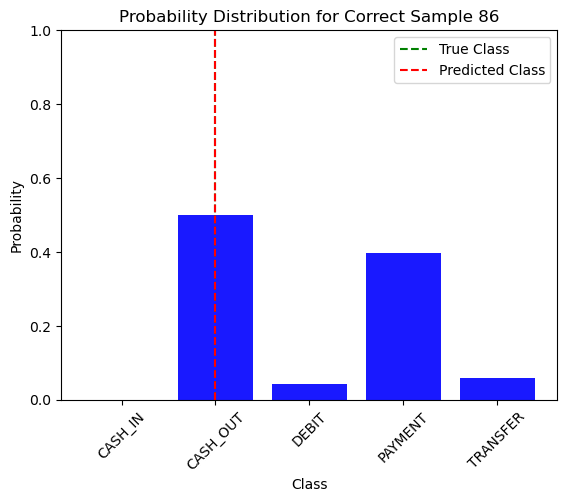

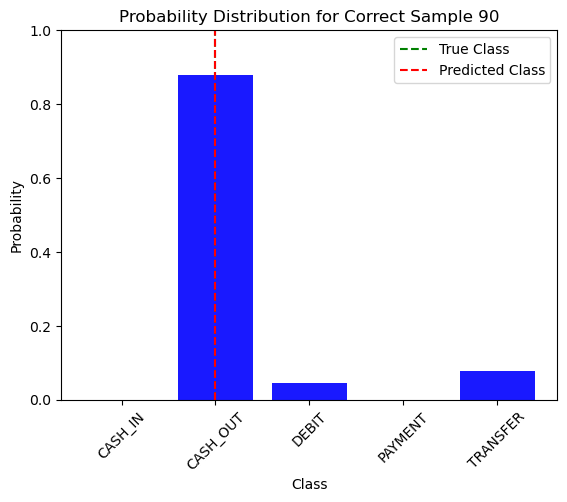

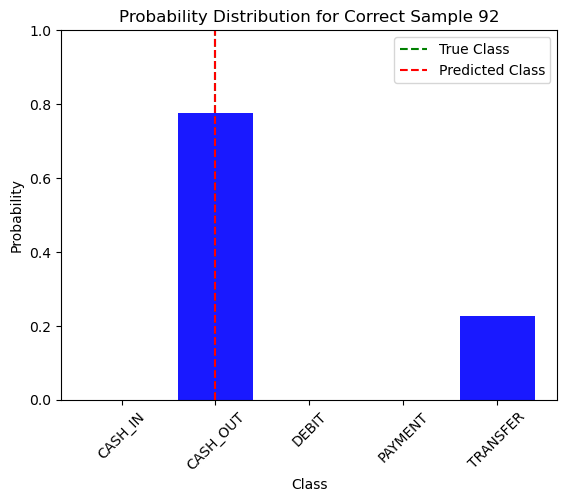

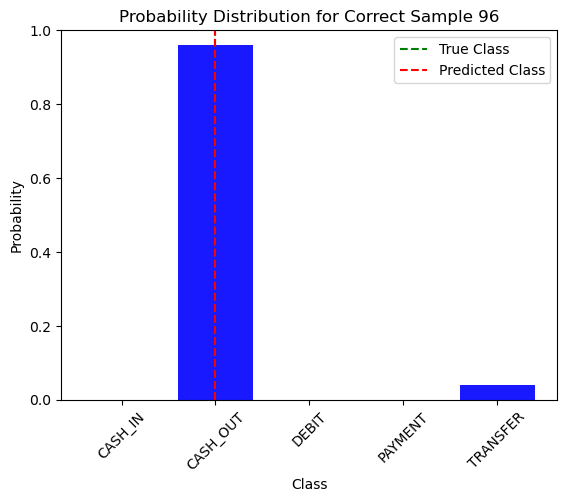

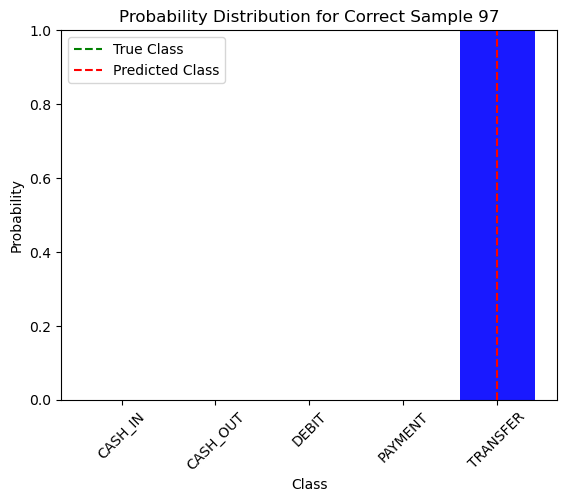

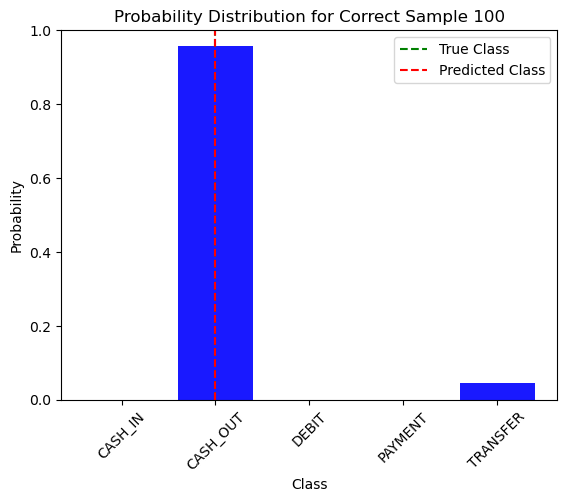

In [165]:
test_plot(testOOD_loader, simple_model)


In [166]:
classes = ['CASH_IN', 'CASH_OUT', 'DEBIT', 'PAYMENT', 'TRANSFER']

def test_count_low_confidence(loader, model):
    model.eval()
    low_confidence_correct_count = 0  # Counter for correctly predicted samples with low confidence
    with torch.no_grad():
        for idx in range(len(loader.dataset)):  # Iterate over the dataset
            data, target = loader.dataset[idx]
            data = data.unsqueeze(0)  # Add batch dimension
            output = model(data)
            probabilities = F.softmax(output, dim=1)
            sample_probs = probabilities[0].numpy()
            correct_label = target.item() if hasattr(target, 'item') else target  # Check if target is a tensor
            predicted_label = output.argmax().item()
            max_prob = sample_probs[predicted_label]
            if predicted_label == correct_label and max_prob > 0.6:
                low_confidence_correct_count += 1
    return low_confidence_correct_count

In [167]:
test_count_low_confidence(testOOD_loader, swag_model)


21

In [168]:
test_count_low_confidence(testOOD_loader, simple_model)


18

## detect OOD

In [169]:
import torch
import torch.nn.functional as F

def test_count_low_confidence_ood(loader, model):
    model.eval()
    low_confidence_correct_count = 0  # Counter for correctly predicted samples with low confidence
    ood_count = 0  # Counter for out-of-distribution (OOD) samples
    with torch.no_grad():
        for idx in range(len(loader.dataset)):  # Iterate over the dataset
            data, target = loader.dataset[idx]
            data = data.unsqueeze(0)  # Add batch dimension
            output = model(data)
            probabilities = F.softmax(output, dim=1)
            sample_probs = probabilities[0].numpy()
            correct_label = target.item() if hasattr(target, 'item') else target  # Check if target is a tensor
            predicted_label = output.argmax().item()
            max_prob = sample_probs[predicted_label]
            if predicted_label == correct_label and max_prob > 0.6:
                low_confidence_correct_count += 1
            elif predicted_label != correct_label or max_prob <= 0.6:
                ood_count += 1
    return low_confidence_correct_count, ood_count


## simple(異常資料集)

In [170]:

low_confidence_correct_count, ood_count = test_count_low_confidence_ood(testOOD_loader, simple_model)

total_samples = len(testOOD_loader.dataset)
ood_percentage = (ood_count / total_samples) * 100

print("Simple model Out-of-Distribution (OOD) data percentage: {:.2f}%".format(ood_percentage))


Simple model Out-of-Distribution (OOD) data percentage: 82.00%


## swag(異常資料集)

In [171]:
low_confidence_correct_count, ood_count = test_count_low_confidence_ood(testOOD_loader, swag_model)

total_samples = len(testOOD_loader.dataset)
ood_percentage = (ood_count / total_samples) * 100
print("SWAG model Out-of-Distribution (OOD) data percentage: {:.2f}%".format(ood_percentage))


SWAG model Out-of-Distribution (OOD) data percentage: 79.00%


In [172]:
low_confidence_correct_count, ood_count = test_count_low_confidence_ood(test1_loader, simple_model)

total_samples = len(test1_loader.dataset)
ood_percentage = (ood_count / total_samples) * 100
print("Simple model Out-of-Distribution (OOD) data percentage: {:.2f}%".format(ood_percentage))

Simple model Out-of-Distribution (OOD) data percentage: 9.37%


In [173]:
def calculate_and_display(loader_list, model):
    for idx, loader in enumerate(loader_list):
        low_confidence_correct_count, ood_count = test_count_low_confidence_ood(loader, model)

        total_samples = len(loader.dataset)
        ood_percentage = (ood_count / total_samples) * 100
        print("Test{} Out-of-Distribution (OOD) data percentage: {:.2f}%".format(idx + 1, ood_percentage))

## simple model (正常資料集)

In [174]:
test_loaders = [test1_loader, test2_loader, test3_loader]
calculate_and_display(test_loaders, simple_model)

Test1 Out-of-Distribution (OOD) data percentage: 9.37%
Test2 Out-of-Distribution (OOD) data percentage: 9.24%
Test3 Out-of-Distribution (OOD) data percentage: 9.71%


## swag model(正常資料集)


In [175]:
test_loaders = [test1_loader, test2_loader, test3_loader]
calculate_and_display(test_loaders, swag_model)


Test1 Out-of-Distribution (OOD) data percentage: 9.41%
Test2 Out-of-Distribution (OOD) data percentage: 9.33%
Test3 Out-of-Distribution (OOD) data percentage: 9.68%
